In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import seaborn as sb
import matplotlib.pyplot as plt

import re
import nltk
import string

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


In [2]:
anime_df = pd.read_csv('anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
rating_df = pd.read_csv('rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### Study the dataset

In [4]:
print(f'Shape of Anime Dataframe : {anime_df.shape} \nShape of Ratings Dataframe : {rating_df.shape}')

Shape of Anime Dataframe : (12294, 7) 
Shape of Ratings Dataframe : (7813737, 3)


In [5]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [6]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


### Check for Empty/Null values


In [7]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [8]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [9]:
anime_df.dropna(inplace = True)

In [10]:
anime_df.name[anime_df.name.duplicated()]

10141           Saru Kani Gassen
10194    Shi Wan Ge Leng Xiaohua
Name: name, dtype: object

In [11]:
anime_df[anime_df.name == 'Saru Kani Gassen']

,anime_id,name,genre,type,episodes,rating,members
10140,22399,Saru Kani Gassen,Kids,OVA,1,5.23,62
10141,30059,Saru Kani Gassen,Drama,Movie,1,4.75,76


In [12]:
anime_df[anime_df.name == 'Shi Wan Ge Leng Xiaohua']

,anime_id,name,genre,type,episodes,rating,members
10193,33193,Shi Wan Ge Leng Xiaohua,"Comedy, Parody",ONA,12,6.67,114
10194,33195,Shi Wan Ge Leng Xiaohua,"Action, Adventure, Comedy, Fantasy, Parody",Movie,1,7.07,110


### Data Exploratory

In [13]:
anime_df.type.value_counts()

type
TV         3668
OVA        3284
Movie      2259
Special    1670
ONA         648
Music       488
Name: count, dtype: int64

<Axes: xlabel='type', ylabel='Count'>

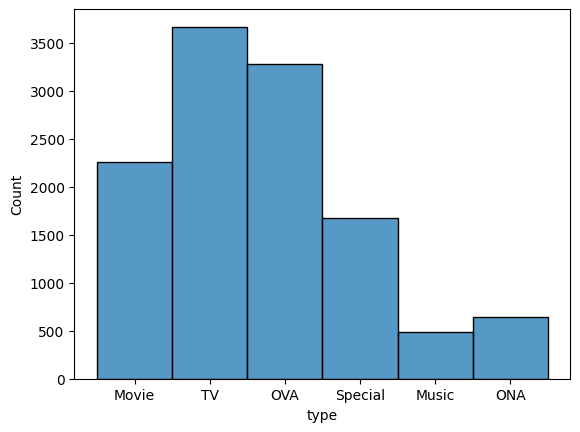

In [14]:
sb.histplot(anime_df.type)

c:\Users\eric2\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


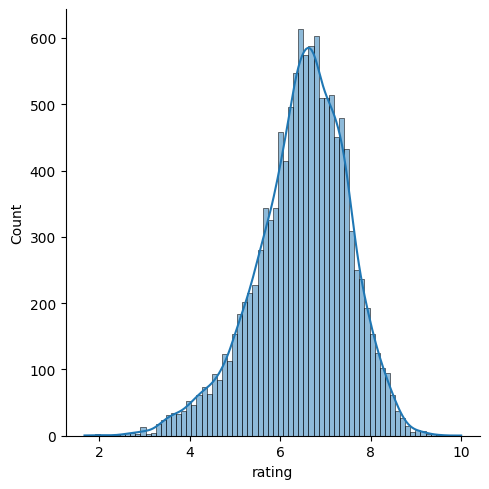

In [15]:
sb.displot(anime_df.rating , kde = True)

In [16]:
genre = anime_df.genre.str.split(', ', expand = True)

counts = genre.apply(pd.Series.value_counts).sum(axis=1)

print(counts)


    

Action           2768.0
Adventure        2316.0
Cars               72.0
Comedy           4575.0
Dementia          238.0
Demons            287.0
Drama            1977.0
Ecchi             628.0
Fantasy          2242.0
Game              177.0
Harem             313.0
Hentai           1133.0
Historical        798.0
Horror            362.0
Josei              52.0
Kids             1598.0
Magic             747.0
Martial Arts      264.0
Mecha             929.0
Military          416.0
Music             842.0
Mystery           485.0
Parody            403.0
Police            195.0
Psychological     226.0
Romance          1437.0
Samurai           146.0
School           1176.0
Sci-Fi           2036.0
Seinen            532.0
Shoujo            594.0
Shoujo Ai          54.0
Shounen          1684.0
Shounen Ai         62.0
Slice of Life    1204.0
Space             377.0
Sports            533.0
Super Power       451.0
Supernatural     1001.0
Thriller           86.0
Vampire           100.0
Yaoi            

In [17]:
counts.index

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music',
       'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen',
       'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power',
       'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object')

Showing the top 5 Genres

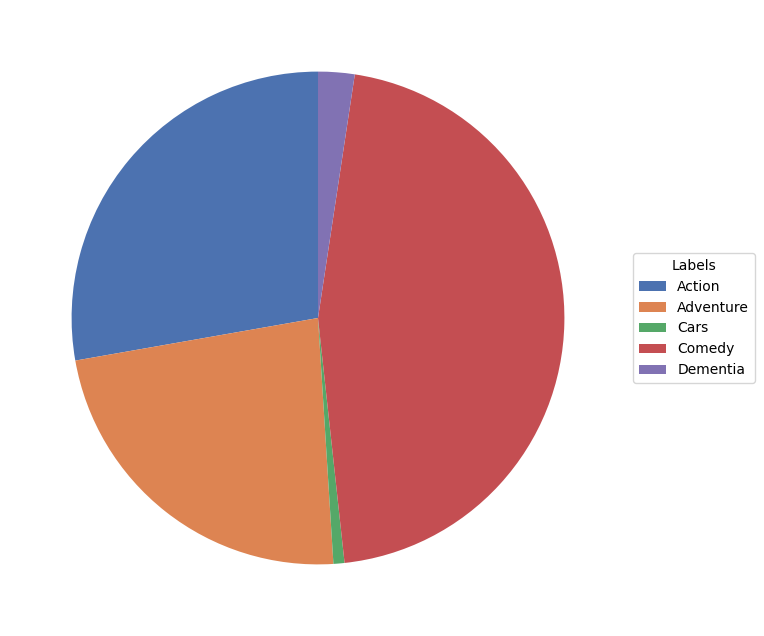

In [18]:
colors = sb.color_palette('deep')[0:len(counts[:5])]
fig,ax = plt.subplots(figsize = (8,8))
label = counts.index.tolist()
wedges, texts, autotexts = ax.pie(counts[:5],  colors = colors, autopct='', startangle=90)
plt.rcParams.update({'font.size': 10})
ax.legend(wedges, label,
          title="Labels",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Ratings -1 are members who have watched but not rated, hence they are removed from this datasets

In [19]:
rating_df = rating_df.loc[rating_df['rating'] >= 0]
rating_df.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


### Merge the Dataset for collaborative filtering

In [20]:
df = anime_df.merge(rating_df, how = 'left', on = 'anime_id')
df.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99.0,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152.0,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244.0,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271.0,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322.0,10.0


In [21]:
df.rename(columns = {'name' : 'anime_title', 'rating_x' : 'overall_rating', 'rating_y': 'user_rating'}, inplace = True)

Text(0, 0.5, 'Ratings')

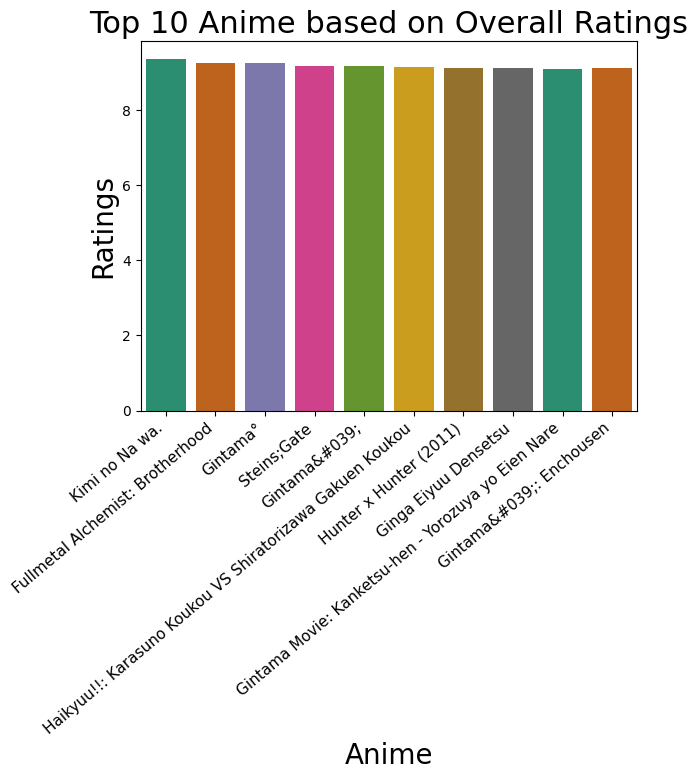

In [22]:
anime_df.sort_values(by = 'rating', ascending = False)
top_10 = anime_df.head(10)

ax = sb.barplot(x = "name", y = "rating", data = top_10, palette= 'Dark2')
ax.set_title('Top 10 Anime based on Overall Ratings', fontsize = 22)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 11, rotation = 40, ha = "right")
ax.set_xlabel('Anime', fontsize = 20)
ax.set_ylabel('Ratings', fontsize = 20)

Text(0, 0.5, 'User Rating count')

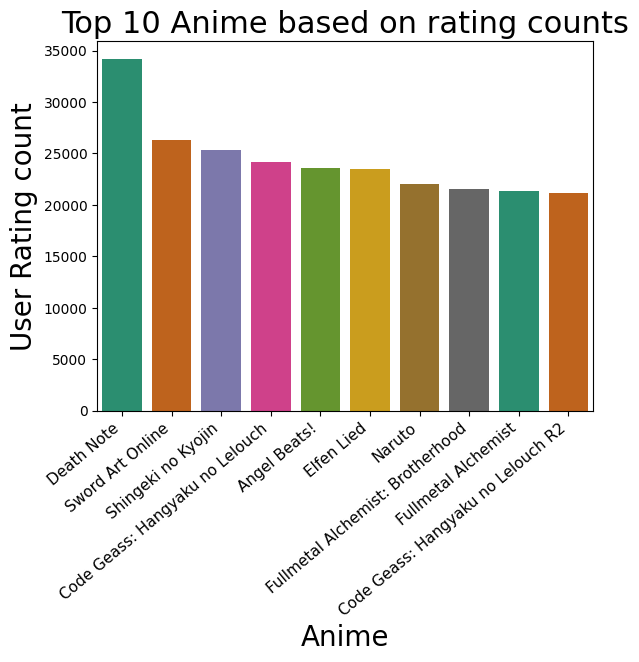

In [23]:
anime_ratingCount = (df.
     groupby(by = ['anime_title'])['user_rating'].
     count().
     reset_index().rename(columns = {'rating': 'totalRatingCount'})
    [['anime_title', 'user_rating']]
    )


top10_animerating=anime_ratingCount[['anime_title', 'user_rating']].sort_values(by = 'user_rating',ascending = False).head(10)
ax=sb.barplot(x="anime_title", y="user_rating", data=top10_animerating, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on rating counts',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

The top 3 anime based on user ratings are Death Note, Sword Art Online and Shingeki no Kyojin

In [24]:
duplicate_anime = df.copy()
duplicate_anime.drop_duplicates(subset = 'anime_title', keep = 'first', inplace = True)

Text(0, 0.5, 'Community Size')

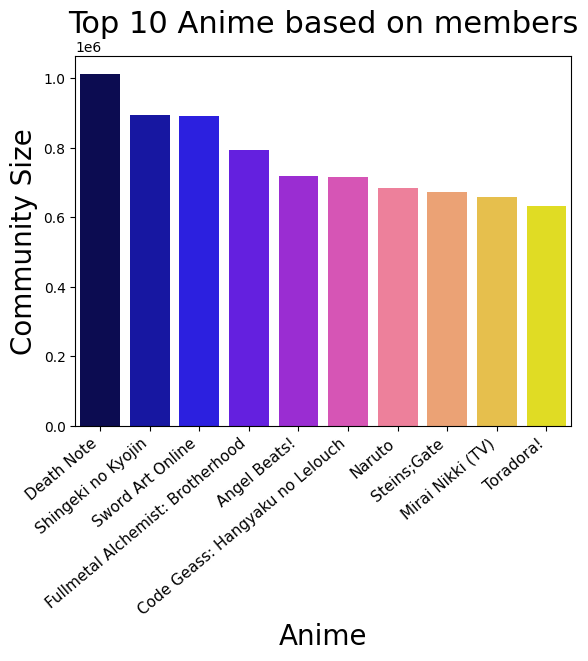

In [25]:
top_10_animemembers=duplicate_anime[['anime_title', 'members']].sort_values(by = 'members',ascending = False).head(10)
ax=sb.barplot(x="anime_title", y="members", data=top_10_animemembers, palette="gnuplot2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on members',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('Community Size', fontsize = 20)

Text(0.5, 1.0, 'User Ratings of Anime')

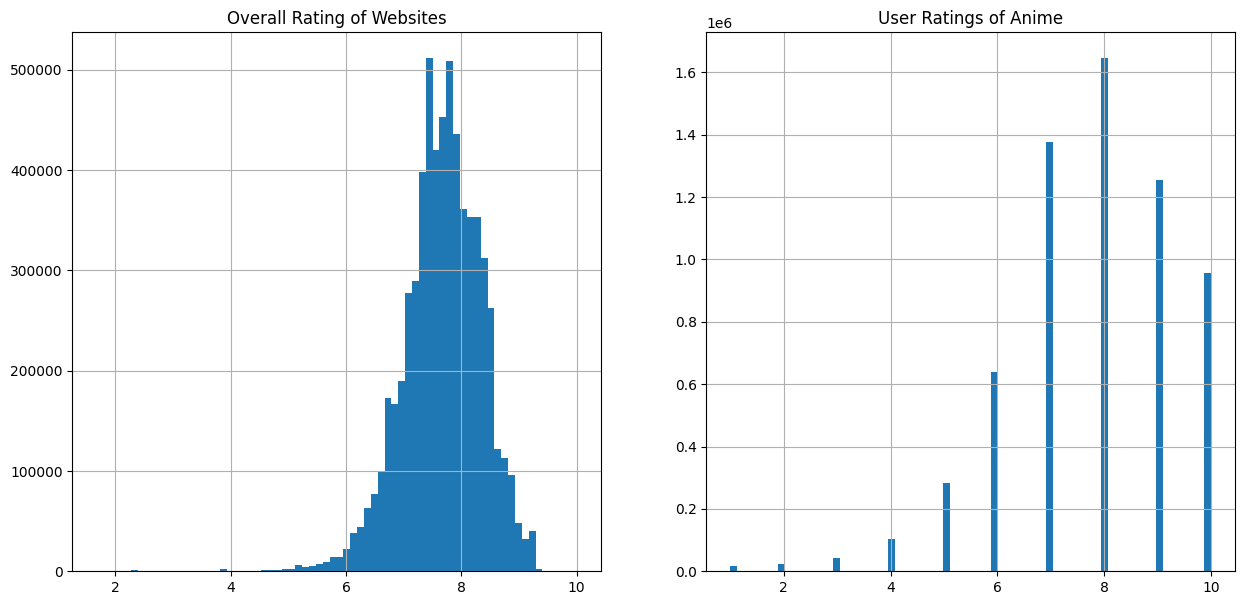

In [26]:
plt.figure(figsize= (15,7))
plt.subplot(1,2,1)
df['overall_rating'].hist(bins=70)
plt.title("Overall Rating of Websites")
plt.subplot(1,2,2)
df['user_rating'].hist(bins=70)
plt.title("User Ratings of Anime")


### Type of Anime

In [27]:
import plotly.graph_objects as go
labels = df['type'].value_counts().index
values = df['type'].value_counts().values
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title={
        'text': "Type of Anime",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

(-0.5, 799.5, 399.5, -0.5)

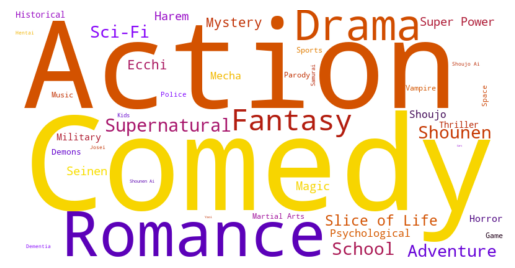

In [28]:
nonull_anime=df.copy()
nonull_anime.dropna(inplace=True)
from collections import defaultdict

all_genres = defaultdict(int)

for genres in nonull_anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1
        
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')

### Data Cleaning

In [29]:
def lower_text(text):
    text = text.lower()
    return text

In [30]:
def clean_text(text):
    
    # to lowercase
    text = text.lower()

    # remove sybmols and other words
    text = re.sub(r'<[^>]*>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
  
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    
    return text

In [31]:
df.head()

,anime_id,anime_title,genre,type,episodes,overall_rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99.0,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152.0,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244.0,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271.0,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322.0,10.0


In [32]:
df["anime_title"] = df["anime_title"].apply(clean_text)

In [33]:
df.head()

,anime_id,anime_title,genre,type,episodes,overall_rating,members,user_id,user_rating
0,32281,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99.0,5.0
1,32281,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152.0,10.0
2,32281,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244.0,10.0
3,32281,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271.0,10.0
4,32281,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322.0,10.0


### Recommender by User's Popularity

In [34]:
def popularity_recommendation(df,name):
    
    group_df = df.groupby(name).agg({'user_rating' : ['mean', 'count']}).reset_index()
    
    group_df.columns = [name, 'mean_rating', 'count']
    
    sort_df = group_df.sort_values('mean_rating', ascending = False)
    
    # Filter off those with only 1 user_ratings that might affect the recommender's decision
    return sort_df[sort_df['count'] > 50].head(10)
   

In [35]:
popularity_recommendation(df,"anime_title")

,anime_title,mean_rating,count
3244,gintama°,9.449495,1188
5268,kimi no na wa,9.426313,1961
3180,ginga eiyuu densetsu,9.389788,803
2767,fullmetal alchemist brotherhood,9.322741,21494
10025,steinsgate,9.261326,17151
3232,gintama,9.251660,7379
4187,hunter x hunter 2011,9.234586,7477
3234,gintama enchousen,9.202258,2126
3237,gintama movie kanketsuhen yorozuya yo eien nare,9.191430,2147
3517,haikyuu karasuno koukou vs shiratorizawa gakue...,9.171484,1038


In [36]:
df['first_genre'] = df['genre'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)


In [37]:
popularity_recommendation(df,"first_genre")

,first_genre,mean_rating,count
14,Josei,8.574034,7348
28,Sci-Fi,8.502633,45572
21,Mystery,8.355527,118562
24,Psychological,8.327117,14640
6,Drama,7.952341,513330
9,Game,7.870670,13423
0,Action,7.867908,2663843
4,Dementia,7.863052,23863
1,Adventure,7.798738,551839
2,Cars,7.756006,1332


### Clustering and Collaborative Recommender

In [38]:
le = LabelEncoder()

df["trans_genre"] = le.fit_transform(df["genre"])
df["trans_type"] = le.fit_transform(df["type"])

In [39]:
df.tail()

,anime_id,anime_title,genre,type,episodes,overall_rating,members,user_id,user_rating,first_genre,trans_genre,trans_type
6339266,5543,under world,Hentai,OVA,1,4.28,183,49503.0,4.0,Hentai,2874,3
6339267,5543,under world,Hentai,OVA,1,4.28,183,58483.0,1.0,Hentai,2874,3
6339268,5621,violence gekiga david no hoshi,Hentai,OVA,4,4.88,219,49503.0,6.0,Hentai,2874,3
6339269,6133,violence gekiga shin david no hoshi inma densetsu,Hentai,OVA,1,4.98,175,60365.0,4.0,Hentai,2874,3
6339270,26081,yasuji no pornorama yacchimae,Hentai,Movie,1,5.46,142,NaN,NaN,Hentai,2874,0


In [40]:
df.dropna(inplace = True)

In [41]:
selected_features = ["anime_id", "trans_genre", "trans_type","user_rating"]

n_clusters = 6
kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
df["clusters"] = kmeans.fit_predict(df[selected_features])

c:\Users\eric2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [42]:
df.head()

,anime_id,anime_title,genre,type,episodes,overall_rating,members,user_id,user_rating,first_genre,trans_genre,trans_type,clusters
0,32281,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99.0,5.0,Drama,2660,0,2
1,32281,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152.0,10.0,Drama,2660,0,2
2,32281,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244.0,10.0,Drama,2660,0,2
3,32281,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271.0,10.0,Drama,2660,0,2
4,32281,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322.0,10.0,Drama,2660,0,2


In [43]:
from collections import Counter

labels = kmeans.labels_

# count of cluster items
cluster_counts = Counter(labels)

for cluster_id, count in cluster_counts.items():
    print(f" Cluster {cluster_id} : {count} elements")

 Cluster 2 : 421801 elements
 Cluster 4 : 1162101 elements
 Cluster 5 : 1097331 elements
 Cluster 1 : 2399825 elements
 Cluster 0 : 685071 elements
 Cluster 3 : 571017 elements


In [66]:
const_cluster_no = 5

In [105]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

start_time = time.time()

# get clusters and set pivot table
df_pivot = df[df.clusters == const_cluster_no].pivot_table(index="anime_title", columns="user_id", values="user_rating").fillna(0)
 
# collaborative filtering method (KNN)
df_matrix = csr_matrix(df_pivot.values)
model_knn = NearestNeighbors(metric="cosine", algorithm="brute")
model_knn.fit(df_matrix)

# random anime title and finding recommendation 
query_no = np.random.choice(df_pivot.shape[0]) 
print(f"Recommendation for anime id:{query_no} which is {df_pivot.index[query_no]}.")
anime_const = df_pivot.index[query_no]

distances, indices = model_knn.kneighbors(df_pivot.iloc[query_no, :].values.reshape(1, -1), n_neighbors=10)

no = []
name = []
distance = []
rating = []
genre = []

# create recommadation
for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f"Recommendations for '{df_pivot.index[query_no]}' viewers :\n")
    else:
        no.append(i)
        name.append(df_pivot.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])
        rating.append(df[df["anime_title"] == df_pivot.index[indices.flatten()[i]]]["overall_rating"].values)
        anime_genre = df[df["anime_title"] == df_pivot.index[indices.flatten()[i]]]["genre"].values
        unique_genre = list(set(anime_genre))
        genre.append(unique_genre)
        



dic = {"No": no, "Anime Name": name, "Rating": rating, "Genre": genre, "Similarity": distance[::-1]}
recommendation = pd.DataFrame(data=dic)
recommendation.set_index("No", inplace=True)

 
end_time = time.time()
elapsed_time = end_time - start_time
print("process time: ", elapsed_time, " sec.")
 
recommendation.head(10)

Recommendation for anime id:1086 which is robinkun to 100 nin no otomodachi.
Recommendations for 'robinkun to 100 nin no otomodachi' viewers :

process time:  8.991644382476807  sec.


,Anime Name,Rating,Genre,Similarity
No,,,,
1,xi yang yang yu hui tai lang zhi hu hu sheng wei,[5.26],"[Adventure, Comedy, Kids]",0.723301
2,kitte no nai okurimono,[5.09],"[Kids, Music]",0.719485
3,shuukan shimakou special,[5.09],[Comedy],0.712632
4,sougen no ko tenguri,"[6.3, 6.3, 6.3, 6.3, 6.3, 6.3, 6.3, 6.3, 6.3, ...","[Adventure, Drama, Historical, Kids]",0.645337
5,trip trek,"[3.64, 3.64, 3.64]","[Adventure, Comedy, Fantasy]",0.641431
6,bara no hana to joe,"[5.92, 5.92, 5.92, 5.92]","[Drama, Kids]",0.580373
7,jigokudou reikai tsuushin,"[6.49, 6.49, 6.49, 6.49, 6.49, 6.49, 6.49, 6.4...","[Fantasy, Horror]",0.552786
8,mugen shinshi bouken katsugekihen,"[5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.76, 5.7...","[Fantasy, Horror, Mystery]",0.552786
9,space neko theater,"[5.38, 5.38, 5.38, 5.38, 5.38, 5.38, 5.38, 5.3...",[Comedy],0.552786


### Clustering and Content Based Recommender System

In [106]:
tf = TfidfVectorizer(analyzer='word')

data = df[df.clusters== const_cluster_no].copy()
data.drop_duplicates(subset = "anime_title", keep = "first", inplace = True)
data.reset_index(drop = True, inplace = True)

genres = data["genre"].str.split(", | , | ,").astype(str)

tfid_matrix = tf.fit_transform(genres)

In [107]:
cosine_sim = cosine_similarity(tfid_matrix,tfid_matrix)

In [108]:
recommend_indices = pd.Series(data.index, index = data["anime_title"]).drop_duplicates()

In [109]:
def collaboration_recommender(title, cosine_sim = cosine_sim):
    idx = recommend_indices[title]
    cosine_scores = list(enumerate(cosine_sim[idx]))
    cosine_scores = sorted(cosine_scores, key = lambda x : x[1], reverse= True)
    cosine_scores = cosine_scores[1:11]
    
    anime_indices = [i[0] for i in cosine_scores]
    
    sim_scores = [i[1] for i in cosine_scores]
    
    recommend_dict = {"No": range(1,11),
                      "Anime Title" : data["anime_title"].iloc[anime_indices].values,
                      "Rating" : data["user_rating"].iloc[anime_indices].values,
                      "Genre" : data["genre"].iloc[anime_indices].values,
                      "Similarity Score" : sim_scores}
    dataframe = pd.DataFrame(data=recommend_dict)
    dataframe.set_index("No", inplace=True)

    print(f"Recommendations for '{title}' viewers :\n")

    return dataframe

In [110]:
collaboration_recommender(anime_const)

Recommendations for 'robinkun to 100 nin no otomodachi' viewers :



,Anime Title,Rating,Genre,Similarity Score
No,,,,
1,shinseiki duel masters flash,2.0,"Comedy, Kids",1.000000
2,backkom,9.0,"Comedy, Kids",1.000000
3,penguin no mondai dx,8.0,"Comedy, Kids",1.000000
4,penguin no mondai max,8.0,"Comedy, Kids",1.000000
5,robinkun to 100 nin no otomodachi,3.0,"Comedy, Kids",1.000000
6,nezha nao hai,6.0,Kids,0.869316
7,cheung gong chat hou,5.0,Kids,0.869316
8,hamster club,10.0,Kids,0.869316
9,tottoko hamtarou ova 2 hamuchanzu no takara sa...,7.0,Kids,0.869316
